Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.

Model saved to: fucked_lstm_model.pt

Loaded model from saved file.

--- Evaluating on PRE-1971 data ---
NSE for t+1: 0.9770
NSE for t+2: 0.9505
NSE for t+3: 0.9092

Overall Test Metrics:
NSE: 0.9456
R2: 0.9456
PBIAS: -6.6523
KGE: 0.9271


C:\Users\Sayuj Gupta\AppData\Local\Temp\ipykernel_44376\3780024991.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


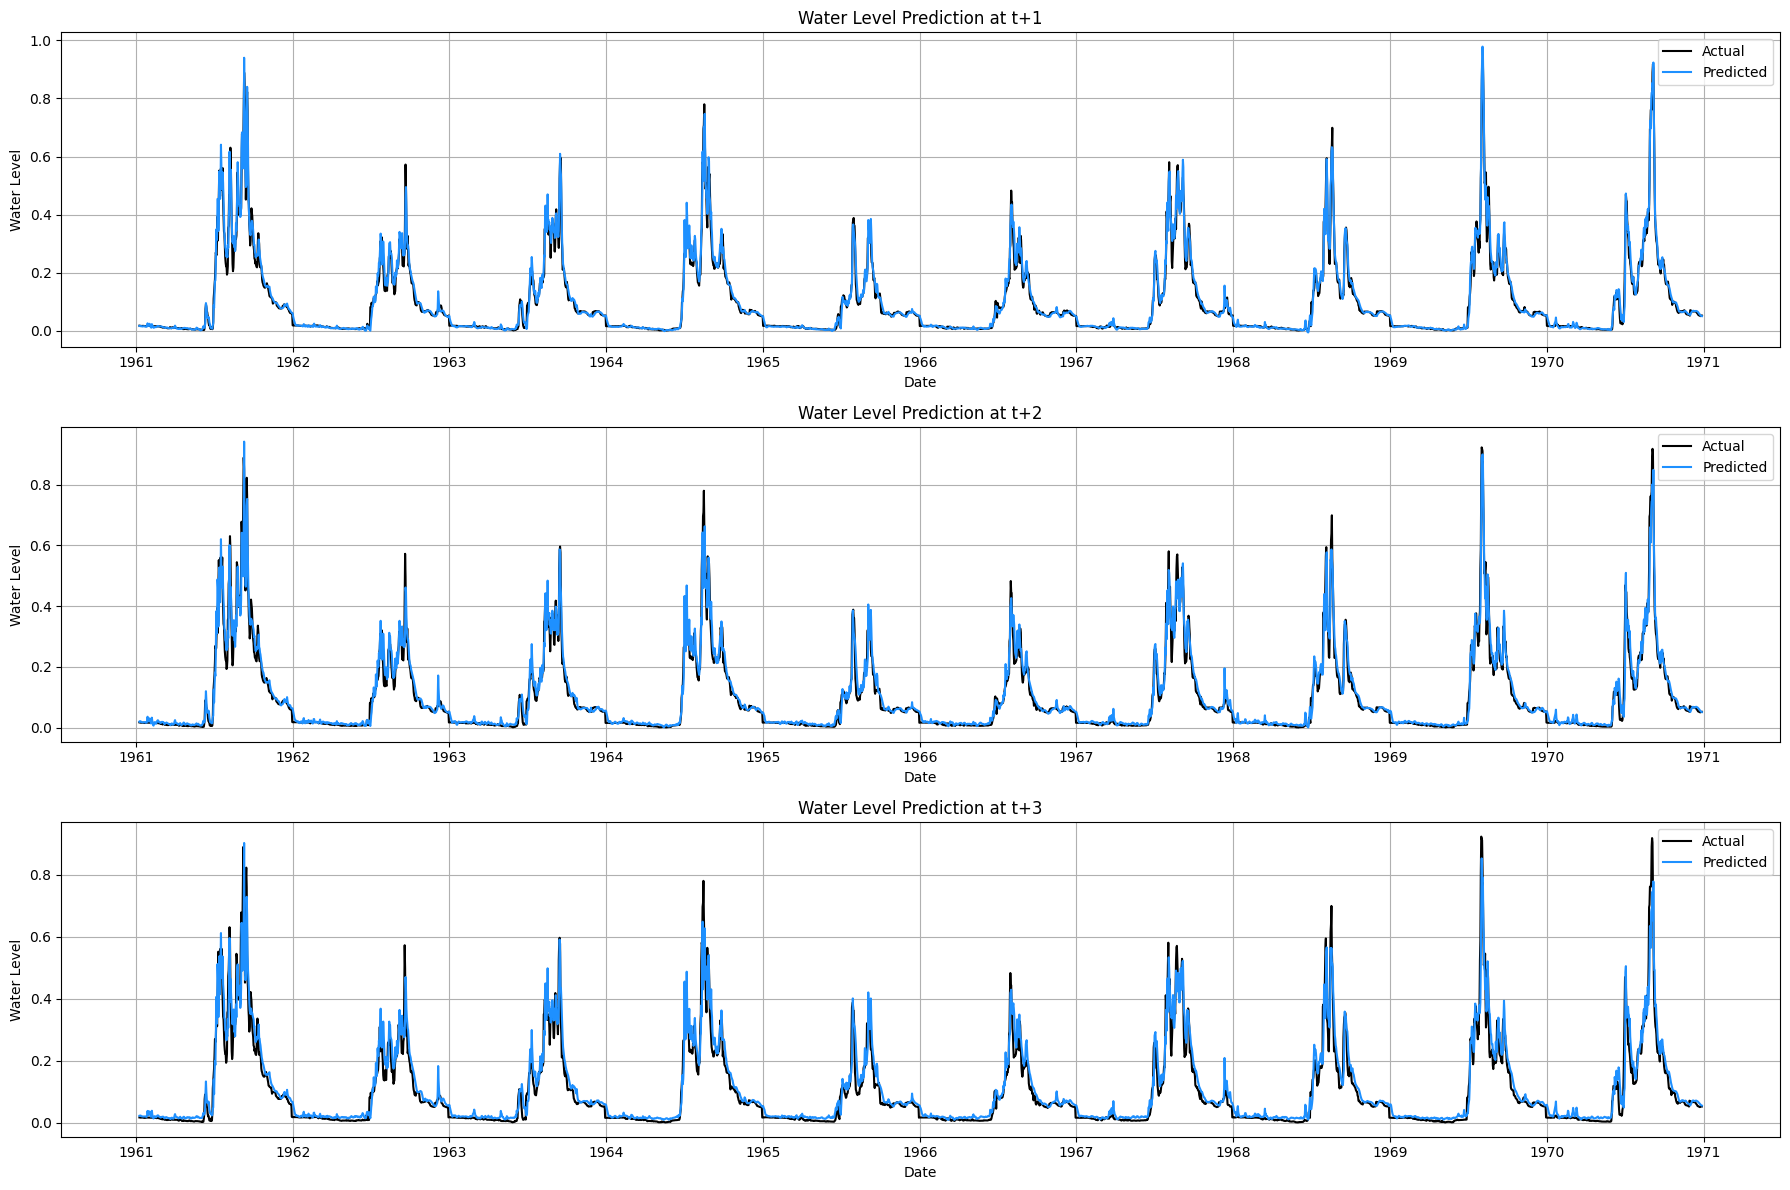


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.8911 (based on 365 samples)
Top 10% NSE at t+2: 0.7316 (based on 365 samples)
Top 10% NSE at t+3: 0.5166 (based on 365 samples)

--- Evaluating on POST-2011 data ---
NSE for t+1: 0.9186
NSE for t+2: 0.8312
NSE for t+3: 0.7578

Overall Test Metrics:
NSE: 0.8359
R2: 0.8359
PBIAS: -0.5826
KGE: 0.9049


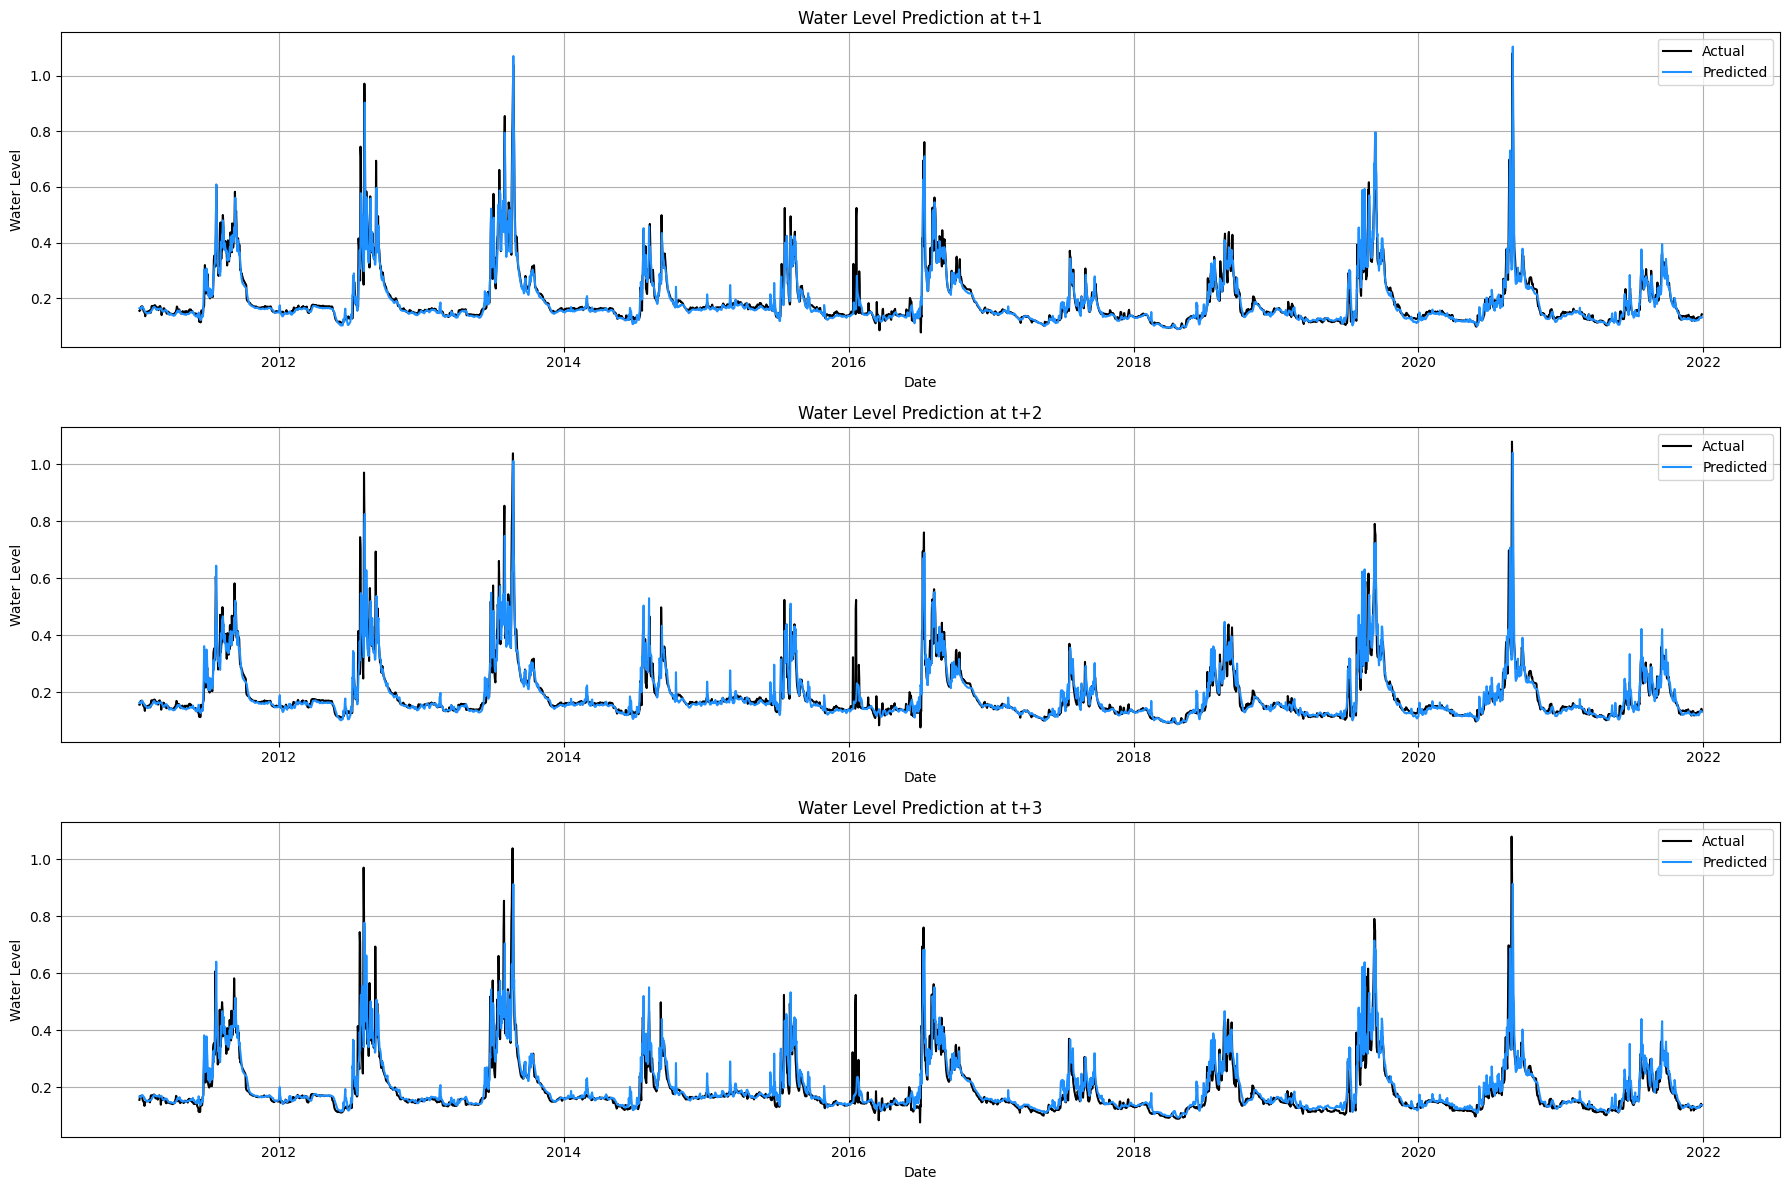


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.6568 (based on 401 samples)
Top 10% NSE at t+2: 0.2028 (based on 401 samples)
Top 10% NSE at t+3: -0.1060 (based on 401 samples)


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === Metrics ===
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def pbias(y_true, y_pred):
    return 100 * (np.sum(y_true - y_pred) / np.sum(y_true))

def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def evaluate(y_true, y_pred):
    return {
        'NSE': nse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'PBIAS': pbias(y_true, y_pred),
        'KGE': kge(y_true, y_pred)
    }

# === Dataset class ===
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_cols, target_col, lookback=30, horizon=3):
        self.X = data[input_cols].values
        self.y = data[target_col].values
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.lookback]  # up to t-1
        y = self.y[idx + self.lookback : idx + self.lookback + self.horizon]  # t+1 to t+3
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# === Load and preprocess data ===
df = pd.read_csv(r'E:\SRIP 2025\Streamflow and Water-level Prediction\LSTM & TFT\LSTM-1upstream\new_Handia_with_hierarchical_quantiles.csv', parse_dates=['date'], dayfirst=True)
df = df.sort_values('date').reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

features = ['rainfall', 'tmin', 'tmax', 'waterlevel_final', 'streamflow_final', 'modelq','Rain_cumulative_3d','Rain_cumulative_7d','waterlevel_upstream','streamflow_upstream','hierarchical_feature_quantile_0.5']
target = 'waterlevel_final'
lookback = 7
horizon = 3

# === Temporal train-test split ===
split_year = 2011
train_df = df[df['year'] < split_year].reset_index(drop=True)
test_df = df[df['year'] >= split_year].reset_index(drop=True)

# Define the three time windows
train_period = (df['date'] >= '1971-01-01') & (df['date'] < '2011-01-01')
pre_test_period = (df['date'] >= '1961-01-01') & (df['date'] < '1971-01-01')
post_test_period = (df['date'] >= '2011-01-01') & (df['date'] <= '2021-12-31')

# Apply the splits
train_df = df[train_period].reset_index(drop=True)
pre_test_df = df[pre_test_period].reset_index(drop=True)
post_test_df = df[post_test_period].reset_index(drop=True)


# Fit scaler only on training data
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
pre_test_df[features] = scaler.transform(pre_test_df[features])
post_test_df[features] = scaler.transform(post_test_df[features])

# Create dataset objects
train_ds = TimeSeriesDataset(train_df, features, target, lookback, horizon)
pre_test_ds = TimeSeriesDataset(pre_test_df, features, target, lookback, horizon)
post_test_ds = TimeSeriesDataset(post_test_df, features, target, lookback, horizon)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
pre_test_loader = DataLoader(pre_test_ds, batch_size=256, shuffle=False)
post_test_loader = DataLoader(post_test_ds, batch_size=256, shuffle=False)


# === Train the model ===
def evaluate_model(model, test_loader, test_df, lookback):
    model.eval()
    y_true, y_pred = [], []
    dates = []

    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            pred = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(pred.numpy())

            batch_dates = test_df['date'].iloc[lookback + i * test_loader.batch_size : lookback + i * test_loader.batch_size + len(xb)]
            dates.extend(batch_dates)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    dates = dates[:len(y_true)]

    # NSE for each horizon
    for i in range(3):
        print(f"NSE for t+{i+1}: {nse(y_true[:, i], y_pred[:, i]):.4f}")

    # Overall metrics
    overall_scores = evaluate(y_true.flatten(), y_pred.flatten())
    print("\nOverall Test Metrics:")
    for k, v in overall_scores.items():
        print(f"{k}: {v:.4f}")

    # === Full time series plot ===
    plt.figure(figsize=(18, 12))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(dates, y_true[:, i], label='Actual', color='black')
        plt.plot(dates, y_pred[:, i], label='Predicted', color='dodgerblue')
        plt.title(f'Water Level Prediction at t+{i+1}')
        plt.xlabel('Date')
        plt.ylabel('Water Level')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Top 10% t+1 only ===
    threshold = np.percentile(y_true[:, 0], 90)
    high_idx = y_true[:, 0] >= threshold

        # === Top 10% NSE per horizon ===
    print("\nNSE for top 10% observed values at each horizon:")
    for i in range(3):
        threshold = np.percentile(y_true[:, i], 90)
        high_idx = y_true[:, i] >= threshold

        if np.sum(high_idx) > 0:
            high_nse = nse(y_true[high_idx, i], y_pred[high_idx, i])
            print(f"Top 10% NSE at t+{i+1}: {high_nse:.4f} (based on {np.sum(high_idx)} samples)")
        else:
            print(f"No values found in top 10% at t+{i+1}.")


def train_model(model, train_loader, num_epochs=25, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} complete.")

    

# === Save path ===
MODEL_PATH = "fucked_lstm_model.pt"

# === Option 1: Train and Save ===
train_flag = True  # SET TO FALSE if you only want to load and evaluate

if train_flag:
    model = LSTMModel(input_size=len(features))
    train_model(model, train_loader, num_epochs=20)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\nModel saved to: {MODEL_PATH}")

# === Option 2: Load and Evaluate ===
model = LSTMModel(input_size=len(features))
model.load_state_dict(torch.load(MODEL_PATH))
print("\nLoaded model from saved file.")

print("\n--- Evaluating on PRE-1971 data ---")
evaluate_model(model, pre_test_loader, pre_test_df, lookback)

print("\n--- Evaluating on POST-2011 data ---")
evaluate_model(model, post_test_loader, post_test_df, lookback)



Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.

Model saved to: fucked_lstm_model_2.pt

Loaded model from saved file.

--- Evaluating on PRE-1971 data ---
NSE for t+1: 0.9262
NSE for t+2: 0.8590
NSE for t+3: 0.7581

Overall Test Metrics:
NSE: 0.8478
R2: 0.8478
PBIAS: -15.2850
KGE: 0.8252


C:\Users\Sayuj Gupta\AppData\Local\Temp\ipykernel_44376\4108534480.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


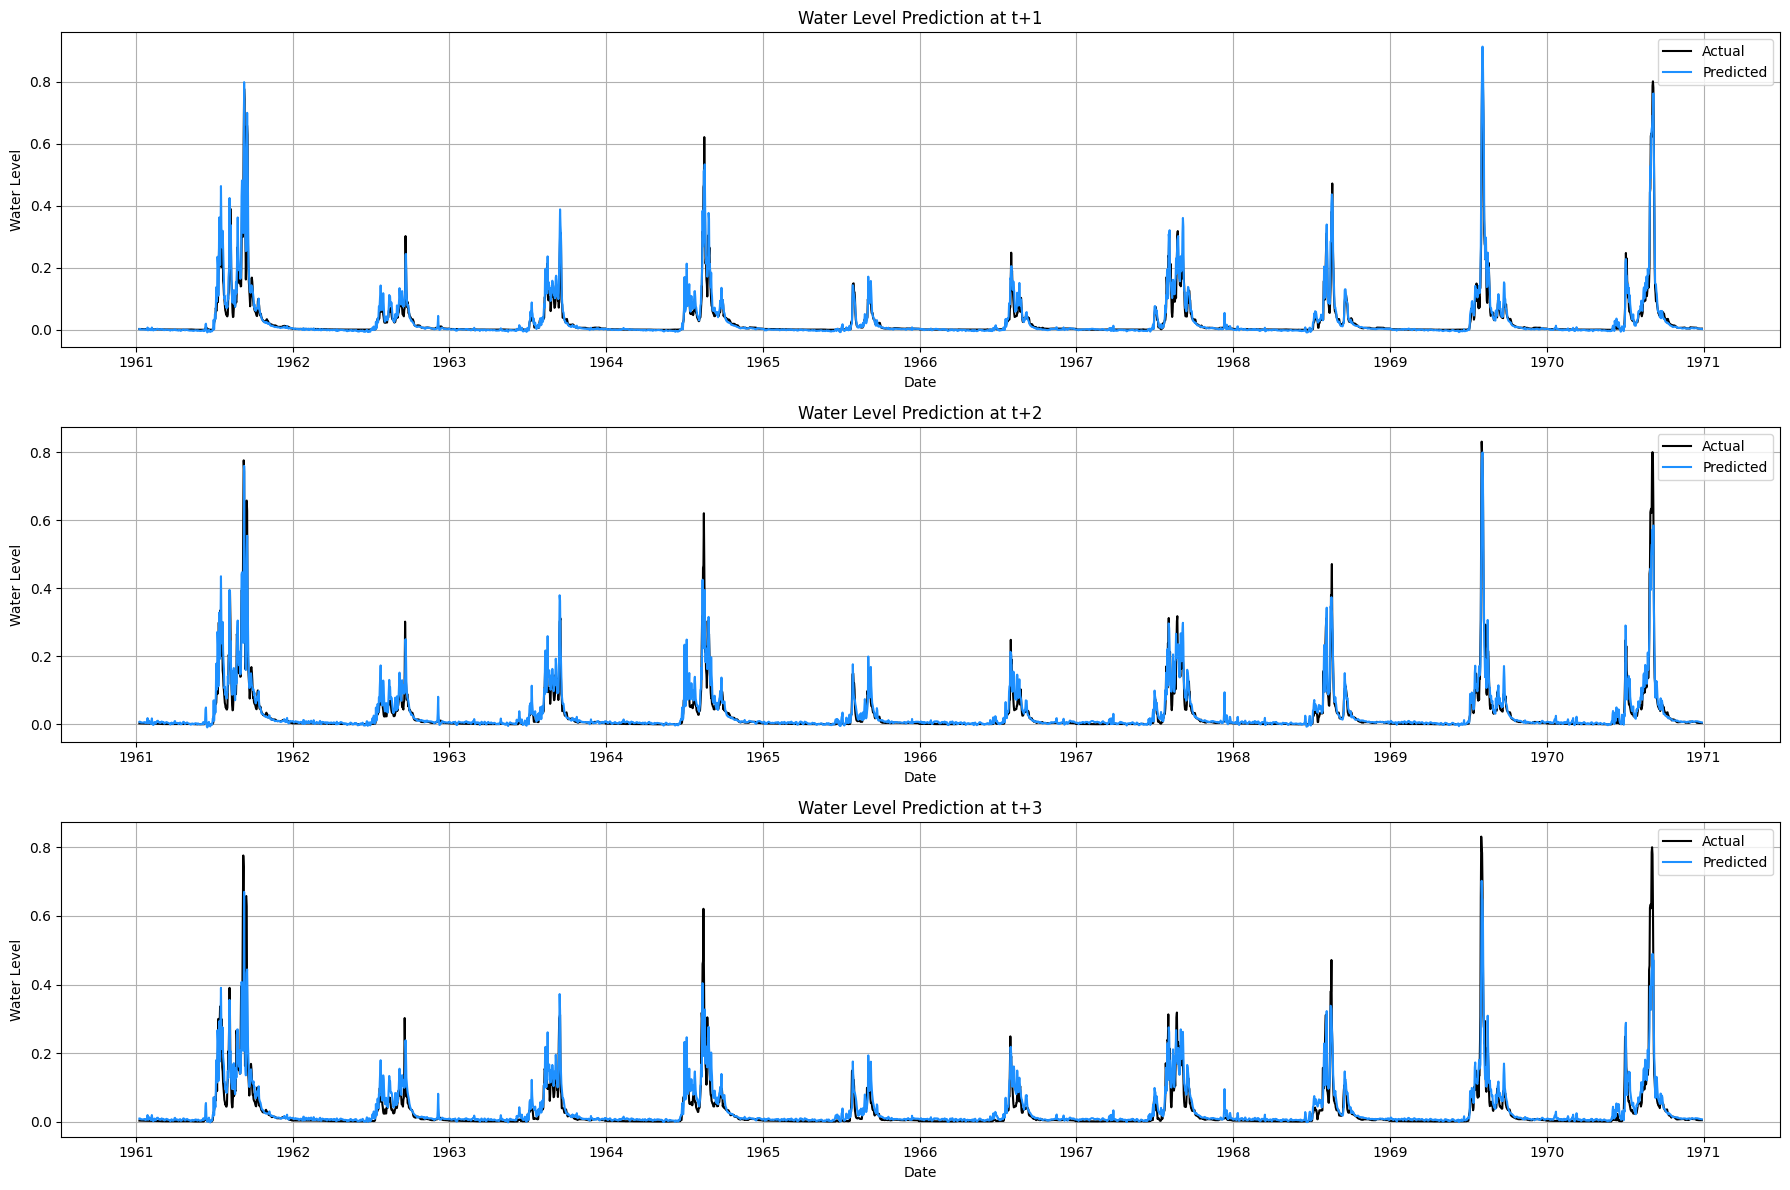


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.8583 (based on 365 samples)
Top 10% NSE at t+2: 0.7312 (based on 365 samples)
Top 10% NSE at t+3: 0.5197 (based on 365 samples)

--- Evaluating on POST-2011 data ---
NSE for t+1: 0.8361
NSE for t+2: 0.6030
NSE for t+3: 0.4437

Overall Test Metrics:
NSE: 0.6276
R2: 0.6276
PBIAS: -15.6577
KGE: 0.7523


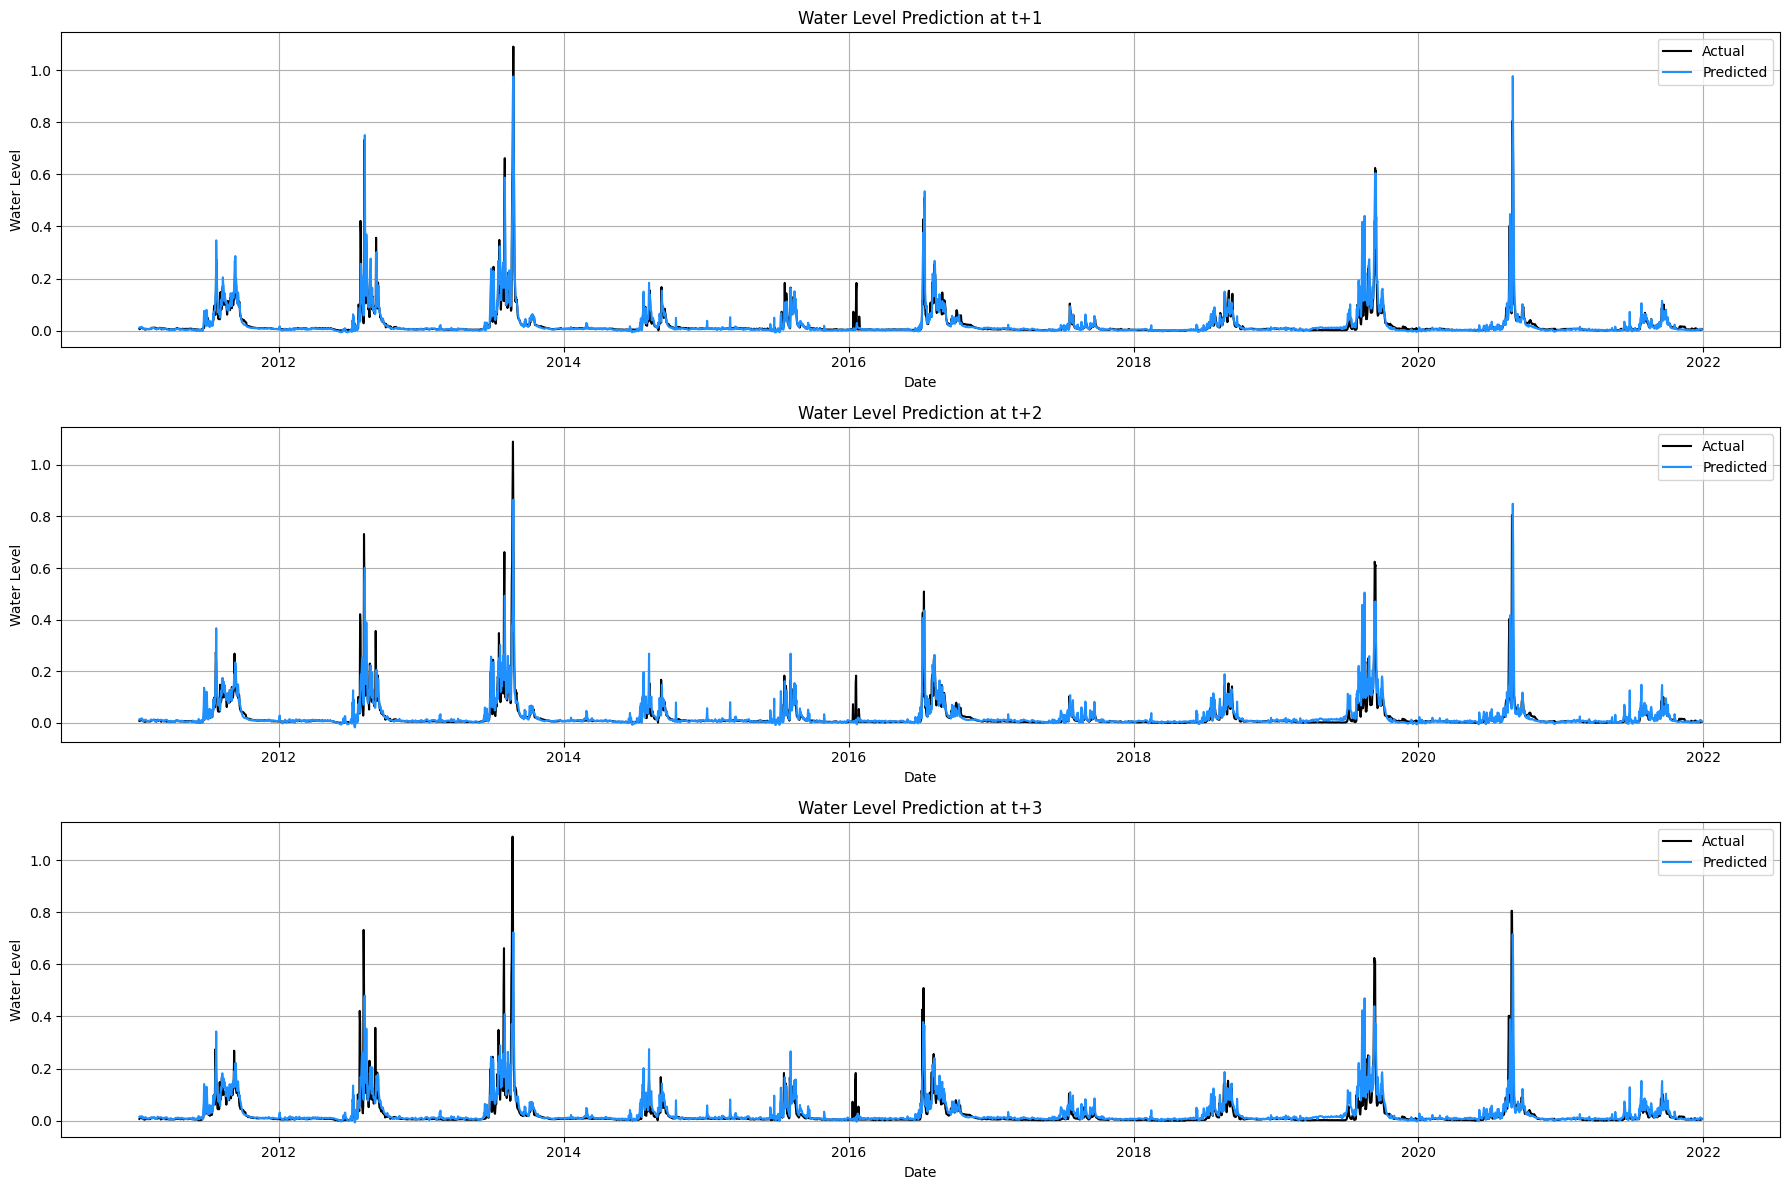


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.7231 (based on 401 samples)
Top 10% NSE at t+2: 0.3077 (based on 401 samples)
Top 10% NSE at t+3: 0.0168 (based on 401 samples)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === Metrics ===
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def pbias(y_true, y_pred):
    return 100 * (np.sum(y_true - y_pred) / np.sum(y_true))

def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def evaluate(y_true, y_pred):
    return {
        'NSE': nse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'PBIAS': pbias(y_true, y_pred),
        'KGE': kge(y_true, y_pred)
    }

# === Dataset class ===
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_cols, target_col, lookback=30, horizon=3):
        self.X = data[input_cols].values
        self.y = data[target_col].values
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.lookback]  # up to t-1
        y = self.y[idx + self.lookback : idx + self.lookback + self.horizon]  # t+1 to t+3
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# === Load and preprocess data ===
df = pd.read_csv(r'E:\SRIP 2025\Streamflow and Water-level Prediction\LSTM & TFT\LSTM-1upstream\new_Handia_with_hierarchical_quantiles.csv', parse_dates=['date'], dayfirst=True)
df = df.sort_values('date').reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

features = ['rainfall', 'tmin', 'tmax', 'waterlevel_final', 'streamflow_final', 'modelq','Rain_cumulative_3d','Rain_cumulative_7d','waterlevel_upstream','streamflow_upstream','hierarchical_feature_quantile_0.5']
target = 'streamflow_final'
lookback = 7
horizon = 3

# === Temporal train-test split ===
split_year = 2011
train_df = df[df['year'] < split_year].reset_index(drop=True)
test_df = df[df['year'] >= split_year].reset_index(drop=True)

# Define the three time windows
train_period = (df['date'] >= '1971-01-01') & (df['date'] < '2011-01-01')
pre_test_period = (df['date'] >= '1961-01-01') & (df['date'] < '1971-01-01')
post_test_period = (df['date'] >= '2011-01-01') & (df['date'] <= '2021-12-31')

# Apply the splits
train_df = df[train_period].reset_index(drop=True)
pre_test_df = df[pre_test_period].reset_index(drop=True)
post_test_df = df[post_test_period].reset_index(drop=True)


# Fit scaler only on training data
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
pre_test_df[features] = scaler.transform(pre_test_df[features])
post_test_df[features] = scaler.transform(post_test_df[features])

# Create dataset objects
train_ds = TimeSeriesDataset(train_df, features, target, lookback, horizon)
pre_test_ds = TimeSeriesDataset(pre_test_df, features, target, lookback, horizon)
post_test_ds = TimeSeriesDataset(post_test_df, features, target, lookback, horizon)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
pre_test_loader = DataLoader(pre_test_ds, batch_size=256, shuffle=False)
post_test_loader = DataLoader(post_test_ds, batch_size=256, shuffle=False)


# === Train the model ===
def evaluate_model(model, test_loader, test_df, lookback):
    model.eval()
    y_true, y_pred = [], []
    dates = []

    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            pred = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(pred.numpy())

            batch_dates = test_df['date'].iloc[lookback + i * test_loader.batch_size : lookback + i * test_loader.batch_size + len(xb)]
            dates.extend(batch_dates)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    dates = dates[:len(y_true)]

    # NSE for each horizon
    for i in range(3):
        print(f"NSE for t+{i+1}: {nse(y_true[:, i], y_pred[:, i]):.4f}")

    # Overall metrics
    overall_scores = evaluate(y_true.flatten(), y_pred.flatten())
    print("\nOverall Test Metrics:")
    for k, v in overall_scores.items():
        print(f"{k}: {v:.4f}")

    # === Full time series plot ===
    plt.figure(figsize=(18, 12))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(dates, y_true[:, i], label='Actual', color='black')
        plt.plot(dates, y_pred[:, i], label='Predicted', color='dodgerblue')
        plt.title(f'Water Level Prediction at t+{i+1}')
        plt.xlabel('Date')
        plt.ylabel('Water Level')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Top 10% t+1 only ===
    threshold = np.percentile(y_true[:, 0], 90)
    high_idx = y_true[:, 0] >= threshold

        # === Top 10% NSE per horizon ===
    print("\nNSE for top 10% observed values at each horizon:")
    for i in range(3):
        threshold = np.percentile(y_true[:, i], 90)
        high_idx = y_true[:, i] >= threshold

        if np.sum(high_idx) > 0:
            high_nse = nse(y_true[high_idx, i], y_pred[high_idx, i])
            print(f"Top 10% NSE at t+{i+1}: {high_nse:.4f} (based on {np.sum(high_idx)} samples)")
        else:
            print(f"No values found in top 10% at t+{i+1}.")


def train_model(model, train_loader, num_epochs=25, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} complete.")

    

# === Save path ===
MODEL_PATH = "fucked_lstm_model_2.pt"

# === Option 1: Train and Save ===
train_flag = True  # SET TO FALSE if you only want to load and evaluate

if train_flag:
    model = LSTMModel(input_size=len(features))
    train_model(model, train_loader, num_epochs=20)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\nModel saved to: {MODEL_PATH}")

# === Option 2: Load and Evaluate ===
model = LSTMModel(input_size=len(features))
model.load_state_dict(torch.load(MODEL_PATH))
print("\nLoaded model from saved file.")

print("\n--- Evaluating on PRE-1971 data ---")
evaluate_model(model, pre_test_loader, pre_test_df, lookback)

print("\n--- Evaluating on POST-2011 data ---")
evaluate_model(model, post_test_loader, post_test_df, lookback)



Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.

Model saved to: fucked_lstm_model_2.pt

Loaded model from saved file.

--- Evaluating on PRE-1971 data ---
NSE for t+1: 0.9707
NSE for t+2: 0.9526
NSE for t+3: 0.9163

Overall Test Metrics:
NSE: 0.9465
R2: 0.9465
PBIAS: -5.1189
KGE: 0.9406


C:\Users\Sayuj Gupta\AppData\Local\Temp\ipykernel_44376\2279343260.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


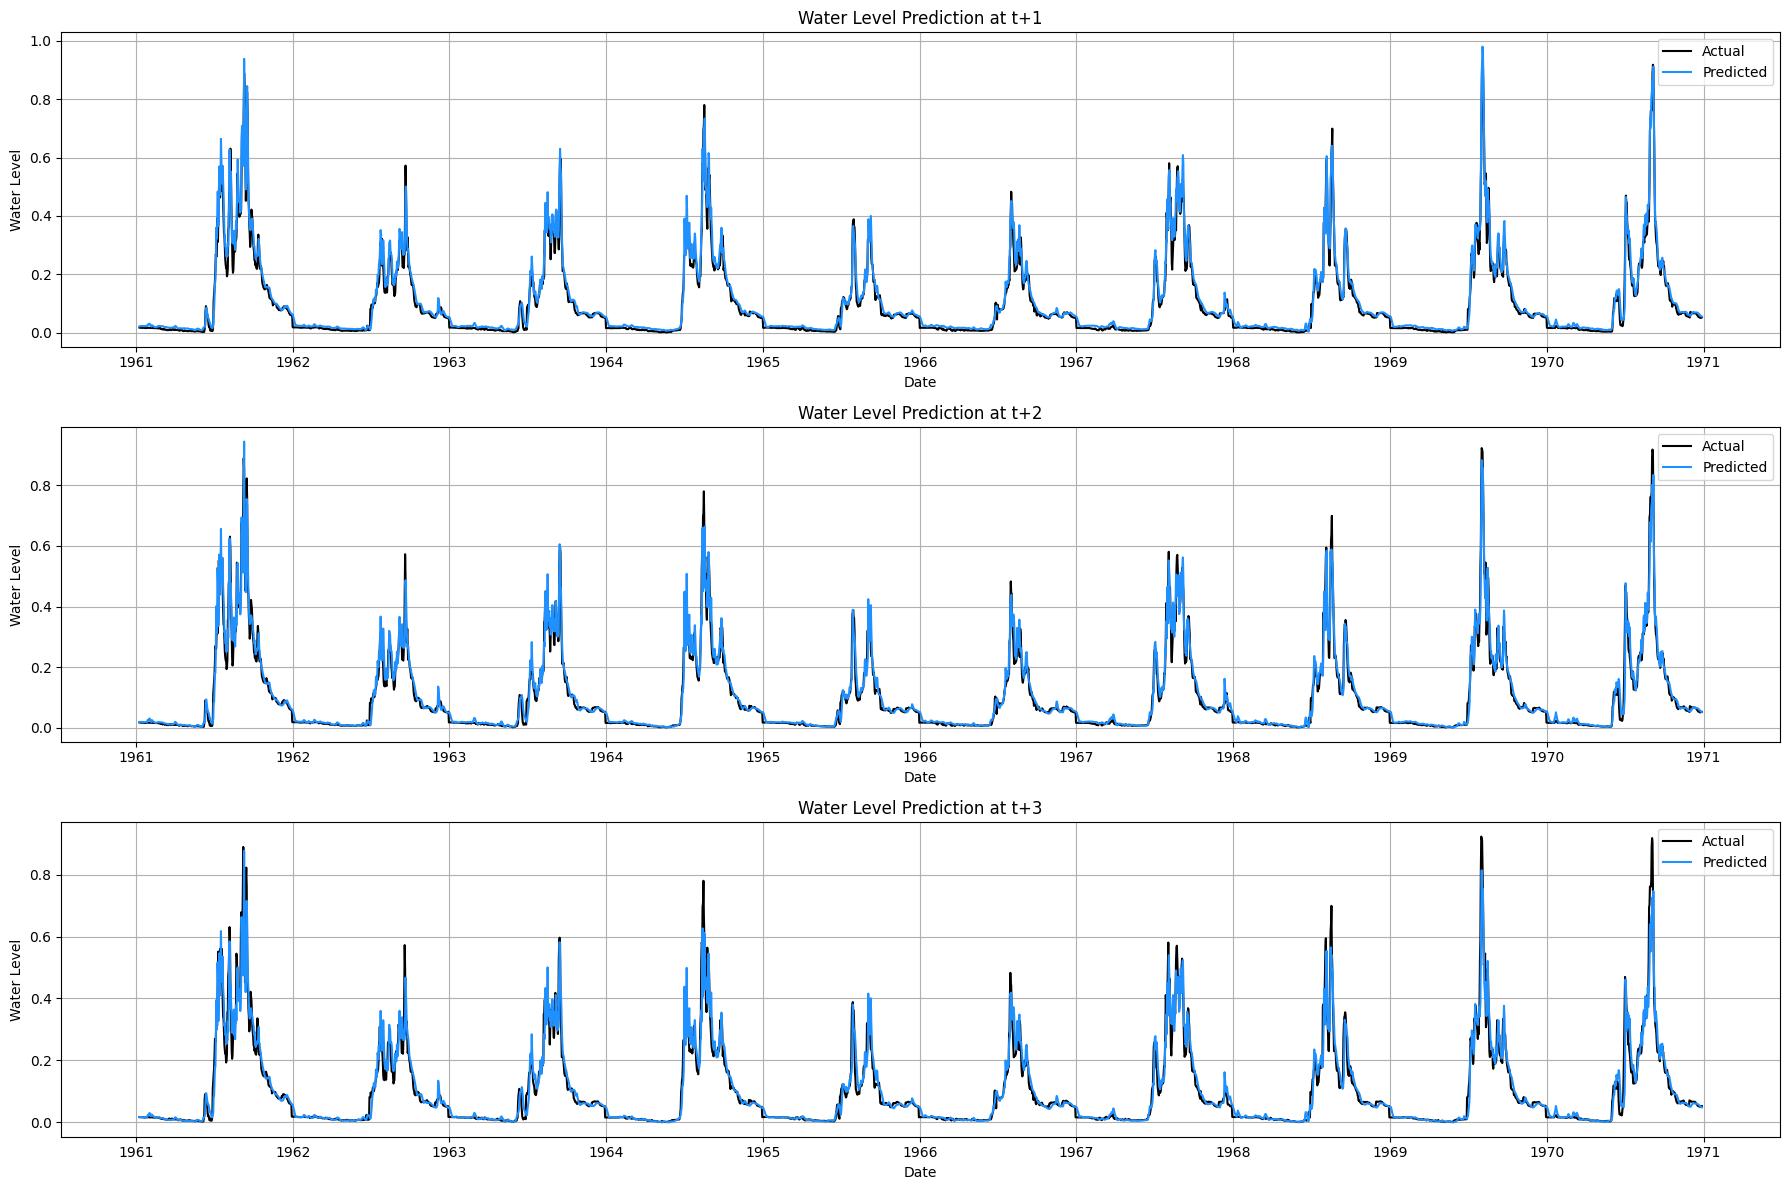


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.8724 (based on 365 samples)
Top 10% NSE at t+2: 0.7338 (based on 365 samples)
Top 10% NSE at t+3: 0.4706 (based on 365 samples)

--- Evaluating on POST-2011 data ---
NSE for t+1: 0.9169
NSE for t+2: 0.8349
NSE for t+3: 0.7660

Overall Test Metrics:
NSE: 0.8393
R2: 0.8393
PBIAS: -0.6053
KGE: 0.9103


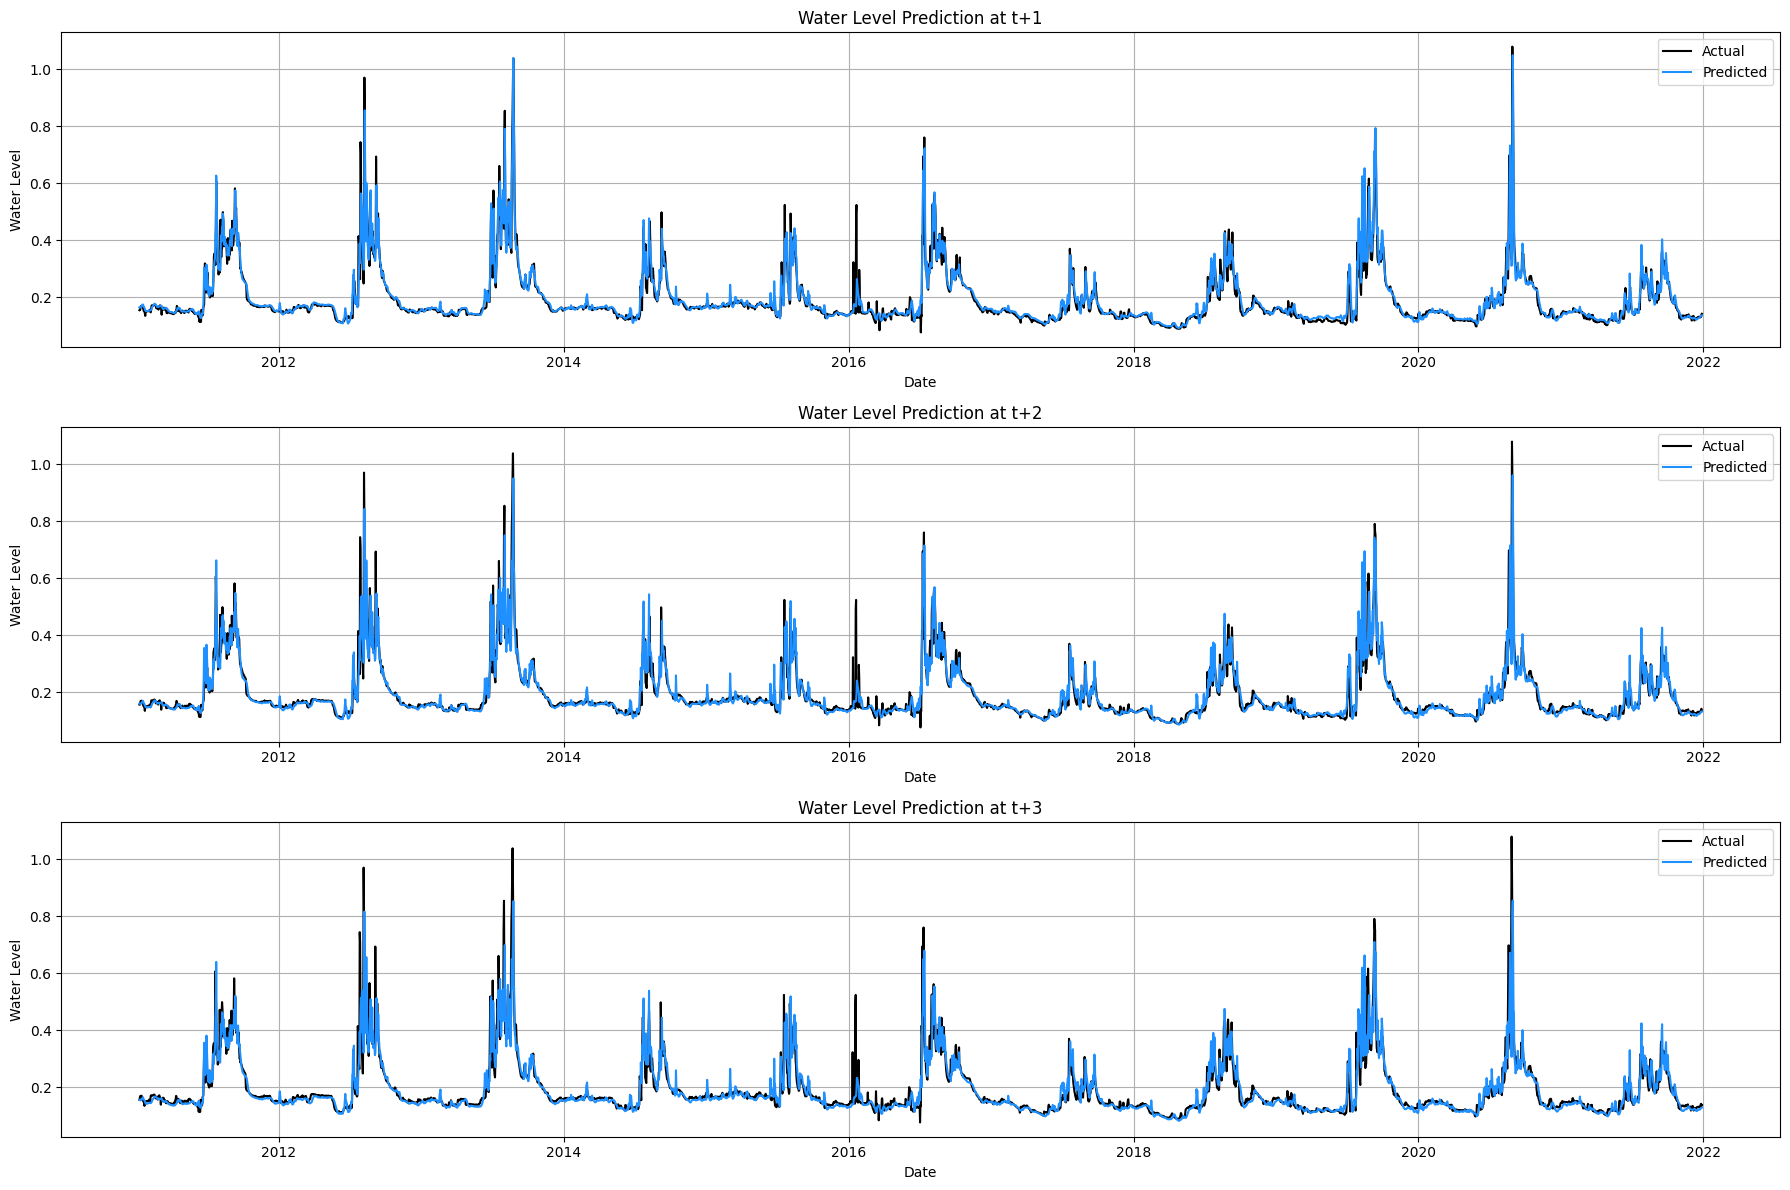


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.6654 (based on 401 samples)
Top 10% NSE at t+2: 0.2193 (based on 401 samples)
Top 10% NSE at t+3: -0.1325 (based on 401 samples)


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === Metrics ===
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def pbias(y_true, y_pred):
    return 100 * (np.sum(y_true - y_pred) / np.sum(y_true))

def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def evaluate(y_true, y_pred):
    return {
        'NSE': nse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'PBIAS': pbias(y_true, y_pred),
        'KGE': kge(y_true, y_pred)
    }

# === Dataset class ===
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_cols, target_col, lookback=30, horizon=3):
        self.X = data[input_cols].values
        self.y = data[target_col].values
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.lookback]  # up to t-1
        y = self.y[idx + self.lookback : idx + self.lookback + self.horizon]  # t+1 to t+3
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        query = lstm_out[:, -1:, :]  # Shape: (batch, 1, hidden_size)
        attn_out, _ = self.attention(query, lstm_out, lstm_out)
        return self.fc(attn_out.squeeze(1))  # Remove the final .squeeze(-1)


# === Load and preprocess data ===
df = pd.read_csv(r'E:\SRIP 2025\Streamflow and Water-level Prediction\LSTM & TFT\LSTM-1upstream\new_Handia_with_hierarchical_quantiles.csv', parse_dates=['date'], dayfirst=True)
df = df.sort_values('date').reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

features = ['rainfall', 'tmin', 'tmax', 'waterlevel_final', 'streamflow_final', 'modelq','Rain_cumulative_3d','Rain_cumulative_7d','waterlevel_upstream','streamflow_upstream','hierarchical_feature_quantile_0.5']
target = 'waterlevel_final'
lookback = 7
horizon = 3

# === Temporal train-test split ===
split_year = 2011
train_df = df[df['year'] < split_year].reset_index(drop=True)
test_df = df[df['year'] >= split_year].reset_index(drop=True)

# Define the three time windows
train_period = (df['date'] >= '1971-01-01') & (df['date'] < '2011-01-01')
pre_test_period = (df['date'] >= '1961-01-01') & (df['date'] < '1971-01-01')
post_test_period = (df['date'] >= '2011-01-01') & (df['date'] <= '2021-12-31')

# Apply the splits
train_df = df[train_period].reset_index(drop=True)
pre_test_df = df[pre_test_period].reset_index(drop=True)
post_test_df = df[post_test_period].reset_index(drop=True)


# Fit scaler only on training data
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
pre_test_df[features] = scaler.transform(pre_test_df[features])
post_test_df[features] = scaler.transform(post_test_df[features])

# Create dataset objects
train_ds = TimeSeriesDataset(train_df, features, target, lookback, horizon)
pre_test_ds = TimeSeriesDataset(pre_test_df, features, target, lookback, horizon)
post_test_ds = TimeSeriesDataset(post_test_df, features, target, lookback, horizon)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
pre_test_loader = DataLoader(pre_test_ds, batch_size=256, shuffle=False)
post_test_loader = DataLoader(post_test_ds, batch_size=256, shuffle=False)


# === Train the model ===
def evaluate_model(model, test_loader, test_df, lookback):
    model.eval()
    y_true, y_pred = [], []
    dates = []

    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            pred = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(pred.numpy())

            batch_dates = test_df['date'].iloc[lookback + i * test_loader.batch_size : lookback + i * test_loader.batch_size + len(xb)]
            dates.extend(batch_dates)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    dates = dates[:len(y_true)]

    # NSE for each horizon
    for i in range(3):
        print(f"NSE for t+{i+1}: {nse(y_true[:, i], y_pred[:, i]):.4f}")

    # Overall metrics
    overall_scores = evaluate(y_true.flatten(), y_pred.flatten())
    print("\nOverall Test Metrics:")
    for k, v in overall_scores.items():
        print(f"{k}: {v:.4f}")

    # === Full time series plot ===
    plt.figure(figsize=(18, 12))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(dates, y_true[:, i], label='Actual', color='black')
        plt.plot(dates, y_pred[:, i], label='Predicted', color='dodgerblue')
        plt.title(f'Water Level Prediction at t+{i+1}')
        plt.xlabel('Date')
        plt.ylabel('Water Level')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Top 10% t+1 only ===
    threshold = np.percentile(y_true[:, 0], 90)
    high_idx = y_true[:, 0] >= threshold

        # === Top 10% NSE per horizon ===
    print("\nNSE for top 10% observed values at each horizon:")
    for i in range(3):
        threshold = np.percentile(y_true[:, i], 90)
        high_idx = y_true[:, i] >= threshold

        if np.sum(high_idx) > 0:
            high_nse = nse(y_true[high_idx, i], y_pred[high_idx, i])
            print(f"Top 10% NSE at t+{i+1}: {high_nse:.4f} (based on {np.sum(high_idx)} samples)")
        else:
            print(f"No values found in top 10% at t+{i+1}.")


def train_model(model, train_loader, num_epochs=25, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} complete.")

    

# === Save path ===
MODEL_PATH = "fucked_lstm_model_2.pt"

# === Option 1: Train and Save ===
train_flag = True  # SET TO FALSE if you only want to load and evaluate

if train_flag:
    model = LSTMModel(input_size=len(features))
    train_model(model, train_loader, num_epochs=20)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\nModel saved to: {MODEL_PATH}")

# === Option 2: Load and Evaluate ===
model = LSTMModel(input_size=len(features))
model.load_state_dict(torch.load(MODEL_PATH))
print("\nLoaded model from saved file.")

print("\n--- Evaluating on PRE-1971 data ---")
evaluate_model(model, pre_test_loader, pre_test_df, lookback)

print("\n--- Evaluating on POST-2011 data ---")
evaluate_model(model, post_test_loader, post_test_df, lookback)



Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.

Model saved to: fucked_lstm_model_2.pt

Loaded model from saved file.

--- Evaluating on PRE-1971 data ---
NSE for t+1: 0.9123
NSE for t+2: 0.8551
NSE for t+3: 0.7577

Overall Test Metrics:
NSE: 0.8417
R2: 0.8417
PBIAS: -11.0788
KGE: 0.8377


C:\Users\Sayuj Gupta\AppData\Local\Temp\ipykernel_44376\3058327701.py:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


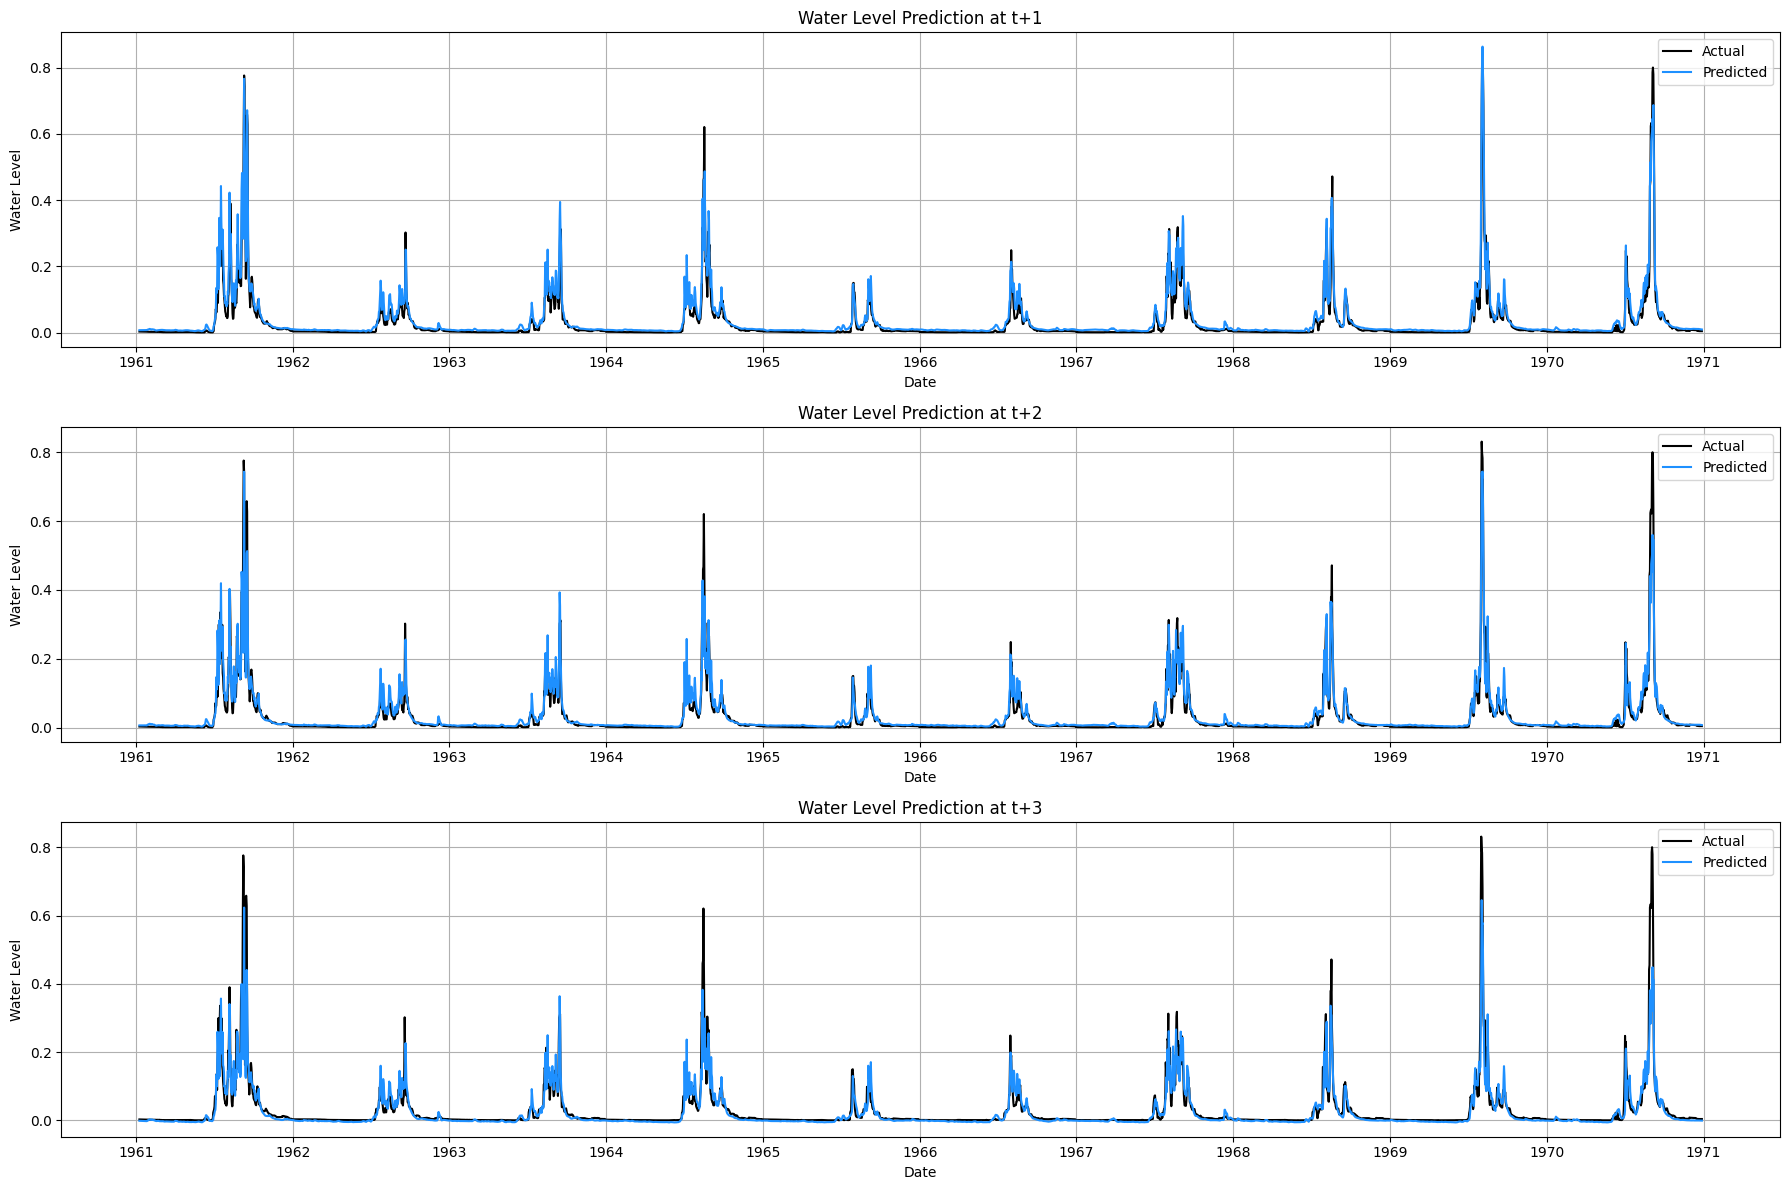


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.8460 (based on 365 samples)
Top 10% NSE at t+2: 0.7113 (based on 365 samples)
Top 10% NSE at t+3: 0.4790 (based on 365 samples)

--- Evaluating on POST-2011 data ---
NSE for t+1: 0.8197
NSE for t+2: 0.6334
NSE for t+3: 0.4914

Overall Test Metrics:
NSE: 0.6482
R2: 0.6482
PBIAS: -15.3971
KGE: 0.7486


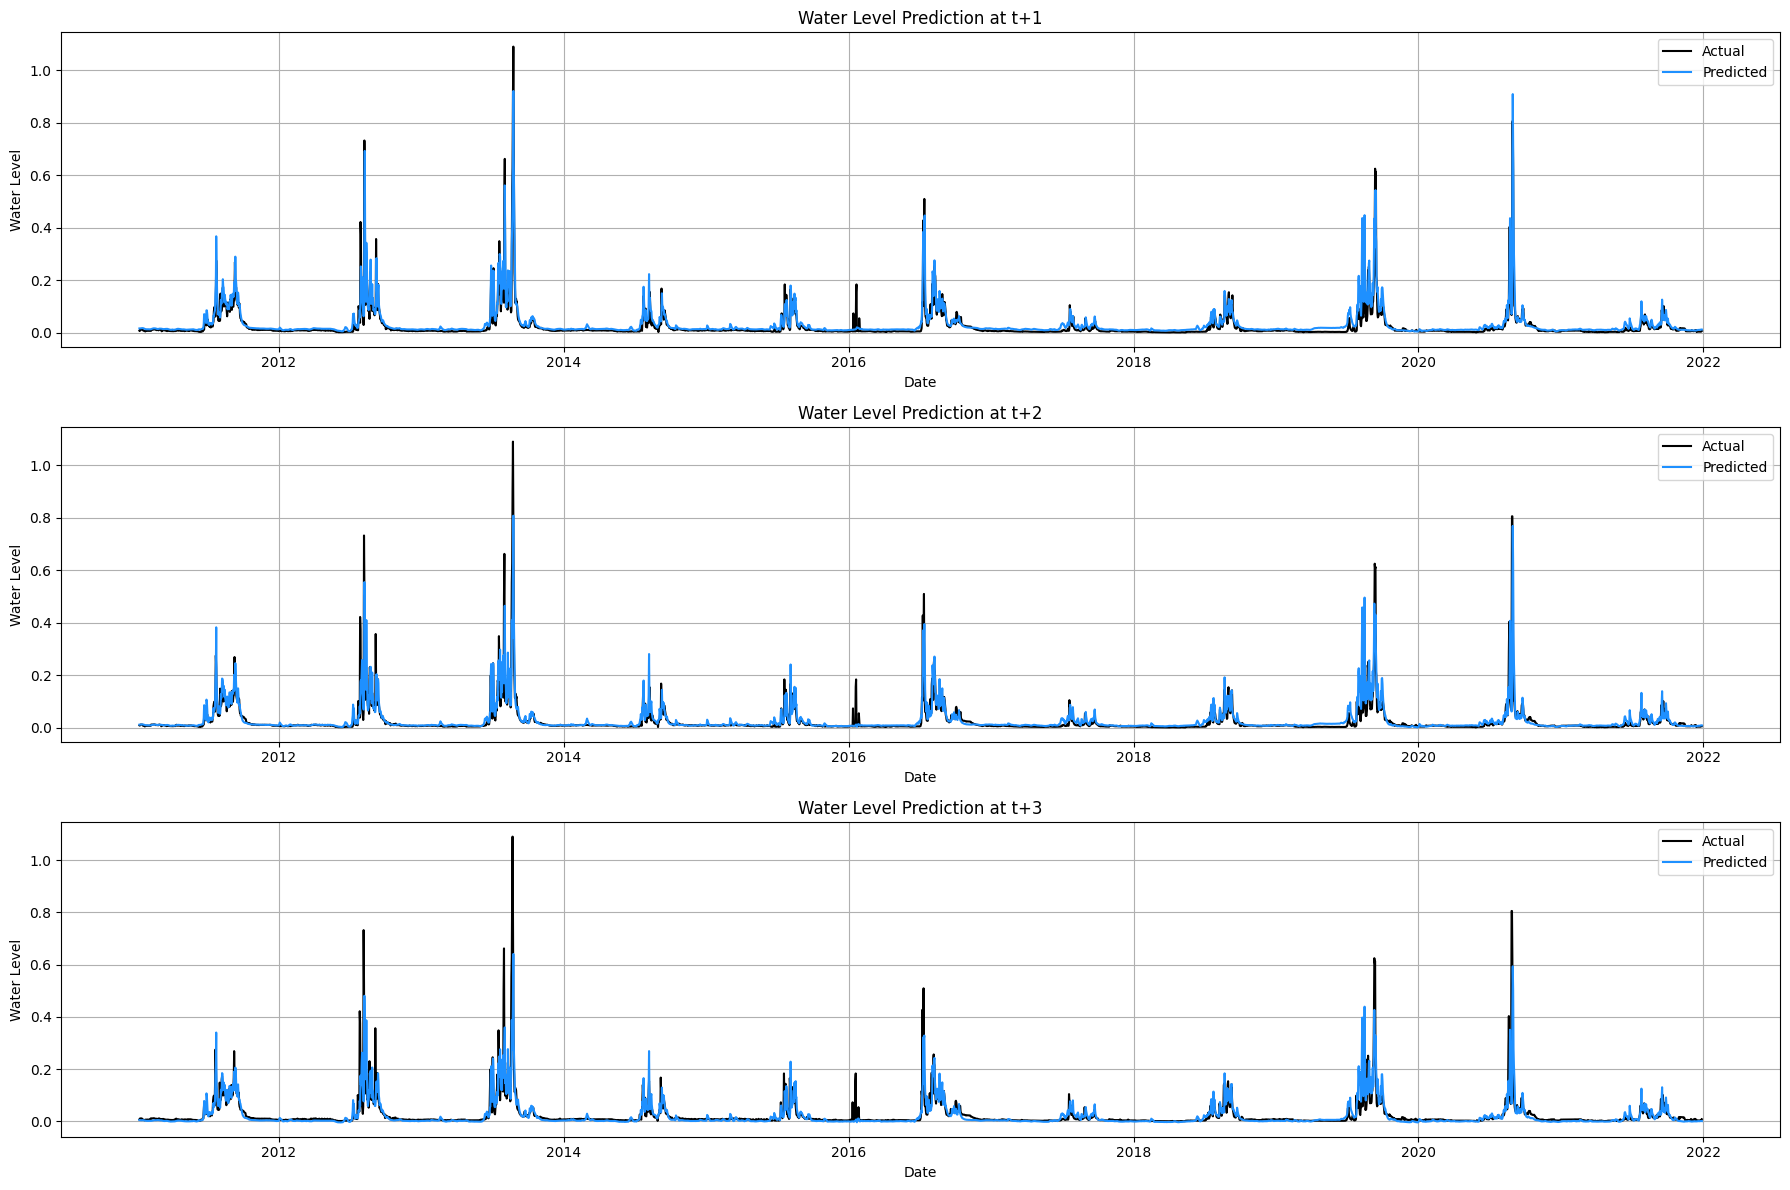


NSE for top 10% observed values at each horizon:
Top 10% NSE at t+1: 0.7200 (based on 401 samples)
Top 10% NSE at t+2: 0.3419 (based on 401 samples)
Top 10% NSE at t+3: 0.0622 (based on 401 samples)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === Metrics ===
def nse(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

def pbias(y_true, y_pred):
    return 100 * (np.sum(y_true - y_pred) / np.sum(y_true))

def kge(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true)
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def evaluate(y_true, y_pred):
    return {
        'NSE': nse(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'PBIAS': pbias(y_true, y_pred),
        'KGE': kge(y_true, y_pred)
    }

# === Dataset class ===
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_cols, target_col, lookback=30, horizon=3):
        self.X = data[input_cols].values
        self.y = data[target_col].values
        self.lookback = lookback
        self.horizon = horizon

    def __len__(self):
        return len(self.X) - self.lookback - self.horizon

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.lookback]  # up to t-1
        y = self.y[idx + self.lookback : idx + self.lookback + self.horizon]  # t+1 to t+3
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, output_size=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        query = lstm_out[:, -1:, :]  # Shape: (batch, 1, hidden_size)
        attn_out, _ = self.attention(query, lstm_out, lstm_out)
        return self.fc(attn_out.squeeze(1))  # Remove the final .squeeze(-1)

# === Load and preprocess data ===
df = pd.read_csv(r'E:\SRIP 2025\Streamflow and Water-level Prediction\LSTM & TFT\LSTM-1upstream\new_Handia_with_hierarchical_quantiles.csv', parse_dates=['date'], dayfirst=True)
df = df.sort_values('date').reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

features = ['rainfall', 'tmin', 'tmax', 'waterlevel_final', 'streamflow_final', 'modelq','Rain_cumulative_3d','Rain_cumulative_7d','waterlevel_upstream','streamflow_upstream','hierarchical_feature_quantile_0.5']
target = 'streamflow_final'
lookback = 7
horizon = 3

# === Temporal train-test split ===
split_year = 2011
train_df = df[df['year'] < split_year].reset_index(drop=True)
test_df = df[df['year'] >= split_year].reset_index(drop=True)

# Define the three time windows
train_period = (df['date'] >= '1971-01-01') & (df['date'] < '2011-01-01')
pre_test_period = (df['date'] >= '1961-01-01') & (df['date'] < '1971-01-01')
post_test_period = (df['date'] >= '2011-01-01') & (df['date'] <= '2021-12-31')

# Apply the splits
train_df = df[train_period].reset_index(drop=True)
pre_test_df = df[pre_test_period].reset_index(drop=True)
post_test_df = df[post_test_period].reset_index(drop=True)


# Fit scaler only on training data
scaler = MinMaxScaler()
train_df[features] = scaler.fit_transform(train_df[features])
pre_test_df[features] = scaler.transform(pre_test_df[features])
post_test_df[features] = scaler.transform(post_test_df[features])

# Create dataset objects
train_ds = TimeSeriesDataset(train_df, features, target, lookback, horizon)
pre_test_ds = TimeSeriesDataset(pre_test_df, features, target, lookback, horizon)
post_test_ds = TimeSeriesDataset(post_test_df, features, target, lookback, horizon)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
pre_test_loader = DataLoader(pre_test_ds, batch_size=256, shuffle=False)
post_test_loader = DataLoader(post_test_ds, batch_size=256, shuffle=False)


# === Train the model ===
def evaluate_model(model, test_loader, test_df, lookback):
    model.eval()
    y_true, y_pred = [], []
    dates = []

    with torch.no_grad():
        for i, (xb, yb) in enumerate(test_loader):
            pred = model(xb)
            y_true.append(yb.numpy())
            y_pred.append(pred.numpy())

            batch_dates = test_df['date'].iloc[lookback + i * test_loader.batch_size : lookback + i * test_loader.batch_size + len(xb)]
            dates.extend(batch_dates)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    dates = dates[:len(y_true)]

    # NSE for each horizon
    for i in range(3):
        print(f"NSE for t+{i+1}: {nse(y_true[:, i], y_pred[:, i]):.4f}")

    # Overall metrics
    overall_scores = evaluate(y_true.flatten(), y_pred.flatten())
    print("\nOverall Test Metrics:")
    for k, v in overall_scores.items():
        print(f"{k}: {v:.4f}")

    # === Full time series plot ===
    plt.figure(figsize=(18, 12))
    for i in range(3):
        plt.subplot(3, 1, i + 1)
        plt.plot(dates, y_true[:, i], label='Actual', color='black')
        plt.plot(dates, y_pred[:, i], label='Predicted', color='dodgerblue')
        plt.title(f'Water Level Prediction at t+{i+1}')
        plt.xlabel('Date')
        plt.ylabel('Water Level')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Top 10% t+1 only ===
    threshold = np.percentile(y_true[:, 0], 90)
    high_idx = y_true[:, 0] >= threshold

        # === Top 10% NSE per horizon ===
    print("\nNSE for top 10% observed values at each horizon:")
    for i in range(3):
        threshold = np.percentile(y_true[:, i], 90)
        high_idx = y_true[:, i] >= threshold

        if np.sum(high_idx) > 0:
            high_nse = nse(y_true[high_idx, i], y_pred[high_idx, i])
            print(f"Top 10% NSE at t+{i+1}: {high_nse:.4f} (based on {np.sum(high_idx)} samples)")
        else:
            print(f"No values found in top 10% at t+{i+1}.")


def train_model(model, train_loader, num_epochs=25, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs} complete.")

    

# === Save path ===
MODEL_PATH = "fucked_lstm_model_2.pt"

# === Option 1: Train and Save ===
train_flag = True  # SET TO FALSE if you only want to load and evaluate

if train_flag:
    model = LSTMModel(input_size=len(features))
    train_model(model, train_loader, num_epochs=20)
    torch.save(model.state_dict(), MODEL_PATH)
    print(f"\nModel saved to: {MODEL_PATH}")

# === Option 2: Load and Evaluate ===
model = LSTMModel(input_size=len(features))
model.load_state_dict(torch.load(MODEL_PATH))
print("\nLoaded model from saved file.")

print("\n--- Evaluating on PRE-1971 data ---")
evaluate_model(model, pre_test_loader, pre_test_df, lookback)

print("\n--- Evaluating on POST-2011 data ---")
evaluate_model(model, post_test_loader, post_test_df, lookback)

